# Importing Modules

In [561]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception, MobileNet
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Directory Path

In [562]:
# Setting the directory path
data_dir = r'C:\Users\saite\OneDrive\Desktop\final project\archive'

In [563]:
# Displaying some sample images
def show_sample_images(generator, num_images=10):
    classes = list(generator.class_indices.keys())

    # Getting a batch of images and labels from the generator
    images, labels = next(generator)

    # Plotting the images with labels
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(classes[int(labels[i].argmax())])
        plt.axis('off')

    plt.show()



# Data Preprocessing

In [564]:
# Creating a list to store file paths and labels
filepaths = []
labels = []

# Evaluating the directory to get file paths and labels
for root, dirs, files in os.walk(data_dir):
    for klass in dirs:
        if klass in ["lung_image_sets", "colon_image_sets"]:
            continue  # Skip the main classes, only consider subclasses
        classpath = os.path.join(root, klass)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

In [565]:
# Creating a DataFrame
data_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Displaying class distribution
print(data_df['labels'].value_counts())

lung_aca                5000
lung_n                  5000
lung_scc                5000
colon_aca               5000
colon_n                 5000
lung_colon_image_set       1
Name: labels, dtype: int64


In [566]:
group = data_df.groupby('labels')
sample_size = 10  # Adjust this to your desired sample size

sample_list = []
for label in data_df['labels'].unique():
    label_group = group.get_group(label).sample(min(sample_size, len(group.get_group(label))), replace=False, random_state=123, axis=0)
    sample_list.append(label_group)

df = pd.concat(sample_list, axis=0).reset_index(drop=True)


# Training and Testing

In [567]:
# Splitting the data into train, test, and validation sets
train_split = 0.8
test_split = 0.1
dummy_split = test_split / (1 - train_split)
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)

# Displaying data split lengths
print('train_df length:', len(train_df), 'test_df length:', len(test_df), 'valid_df length:', len(valid_df))

train_df length: 40 test_df length: 5 valid_df length: 6


# Setting Parameters

In [568]:
# Image parameters
height = 64  # Reduced image height
width = 64   # Reduced image width
channels = 3
batch_size = 32
img_size = (height, width)

In [569]:
# Data augmentation and scaling
gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
train_gen = gen.flow_from_dataframe(train_df, directory=None, x_col='filepaths', y_col='labels',
                                    target_size=img_size, class_mode='categorical', batch_size=batch_size, subset='training')
valid_gen = gen.flow_from_dataframe(valid_df, directory=None, x_col='filepaths', y_col='labels',
                                    target_size=img_size, class_mode='categorical', batch_size=batch_size, subset='validation')
test_gen = gen.flow_from_dataframe(test_df, directory=None, x_col='filepaths', y_col='labels',
                                   target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False)

Found 36 validated image filenames belonging to 5 classes.
Found 0 validated image filenames belonging to 4 classes.
Found 5 validated image filenames belonging to 4 classes.


C:\Users\saite\AppData\Roaming\Python\Python39\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


# Xception and MobileNet Model

In [570]:
# Building a model with Xception and MobileNet
input_layer = Input(shape=(height, width, channels))
xception = Xception(weights='imagenet', include_top=False)(input_layer)
mobilenet = MobileNet(weights='imagenet', include_top=False)(input_layer)
concatenated = Concatenate()([xception, mobilenet])
flat = Flatten()(concatenated)
dense = Dense(units=1024, activation='relu')(flat)
dense = Dense(512, activation='relu')(dense)
dense = Dense(units=256, activation='relu')(dense)
predictions = Dense(5, activation='softmax')(dense)

# Model Summury

In [571]:
# Compiling the model
model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [572]:
# Displaying the model summary
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_64 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 xception (Functional)       (None, None, None, 2048)     2086148   ['input_64[0][0]']            
                                                          0                                       
                                                                                                  
 mobilenet_1.00_224 (Functi  (None, None, None, 1024)     3228864   ['input_64[0][0]']            
 onal)                                                                                            
                                                                                           

# Evaluating Model

In [573]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [574]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [575]:
!pip install --upgrade tensorflow
import tensorflow as tf
tf.config.run_functions_eagerly(True)


Defaulting to user installation because normal site-packages is not writeable


In [576]:
from keras.layers import Input, Dense
from keras.models import Model

# Replace input_size with the actual size of your input data
input_size = 100  # Change this to the actual size of your input data

# Create the input layer
inputs = Input(shape=(input_size,))

# Add your model layers
x = Dense(units=64, activation='relu')(inputs)
x = Dense(units=32, activation='relu')(x)

# Output layer with softmax activation for multi-class classification
num_classes = 5  # Change this to the actual number of classes in your problem
outputs = Dense(num_classes, activation='softmax')(x)

# Create the model by specifying the input and output layers
model = Model(inputs=inputs, outputs=outputs)


In [577]:
from keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [578]:
# Example with 5 classes
output_layer = Dense(5, activation='softmax')


In [579]:
import numpy as np

# Assuming train_data is your raw input data
train_data = np.random.random((10, 10))  # Example data with a compatible size, replace this with your actual data
train_data_reshaped = train_data.reshape((-1, 100))  # Reshape into shape (10, 10) or any other shape with a total size of 100



In [580]:
# Assuming train_data is your raw input data
train_data_reshaped = train_data.reshape((-1, 100))  # Adjust the shape as needed


In [581]:
# Assuming your original data generator produces batches with shape (batch_size, 64, 64, 3)
# Modify it to flatten the input data to shape (batch_size, 100)

class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, data, batch_size):
        self.data = data
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data[index * self.batch_size:(index + 1) * self.batch_size]
        # Flatten the data to shape (batch_size, 100)
        flattened_data = batch_data.reshape((len(batch_data), -1))
        return flattened_data, labels  # Replace "labels" with your actual labels

# Usage example:
train_gen = CustomDataGenerator(train_data, batch_size=32)


In [582]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, input_shape=(10, 10), activation='relu'))  # Adjust input_shape as needed
# Add the rest of your model layers...

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [583]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


In [584]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [585]:
input_shape = (height, width, channels)  # Replace with the actual dimensions of your images


In [586]:
import tensorflow as tf

def preprocess_data(data, target_size=(224, 224)):
    processed_data = []
    for img in data:
        if len(img.shape) == 2:  # Grayscale image, add channel dimension
            img = tf.expand_dims(img, axis=-1)
        # Check the shape of img before resize
        print("Shape before resize:", img.shape)
        img = tf.image.resize(img, target_size)
        # Check the shape of img after resize
        print("Shape after resize:", img.shape)
        processed_data.append(img)
    return processed_data

# Rest of your code...


In [587]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense  # Add other layers as needed

# Create a sequential model
model = Sequential()

# Add a convolutional layer
model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation='relu'))

# Add other layers as needed (e.g., Flatten, Dense)

# Compile the model and specify the optimizer, loss function, and metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [588]:
import os

if not os.path.exists('data'):
    os.makedirs('data')


In [589]:
import numpy as np

# Assuming you have a NumPy array or some other data structure named 'data'
# Replace this line with your actual data loading or generation code
data = np.random.rand(100, 64, 64, 3)

# Reshape the data
data = data.reshape(-1, 64, 64, 3)

# Now you can proceed with the rest of your code
# (e.g., splitting the data into training and validation sets)


In [590]:
import os
print(os.getcwd())


c:\Users\saite\OneDrive\Desktop\final project\coding\coding\Lung and Colon Cancer_Software


In [591]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
# Add more layers as needed for your specific architecture


In [592]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [593]:
# Specify the optimizer and the loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [594]:
import os

train_data_dir = os.path.abspath(r'C:\Users\saite\OneDrive\Desktop\final project\archive\to\train\data')



In [595]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming input_dim is the dimension of your input data
input_dim = 100  # Replace this with the actual input dimension

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dense(10, activation='softmax')
])



In [596]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Assuming you have a Sequential model
model = Sequential()
# Add your layers here...

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Now you can train your model
history = model.fit(x=train_gen, epochs=epochs, callbacks=callbacks, verbose=1,
                    validation_data=valid_gen, validation_steps=None,
                    shuffle=False, initial_epoch=0)


C:\Users\saite\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


AttributeError: 'Sequential' object has no attribute 'set_model'

In [ ]:
epochs =15
patience=9  # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
callbacks=[
    (model, patience, stop_patience, threshold, True),
    # Add more callbacks if needed
]

history=model.fit(x=train_gen,  epochs=epochs, callbacks=callbacks, verbose=1,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

# Training and Validation data

In [ ]:
def plot_training_history(history):
    # Plotting the training and validation data
    plt.figure(figsize=(12, 6))

    # Plotting training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
# Plotting the training and validation data
plot_training_history(history)

# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f'Test accuracy: {test_acc * 100:.2f}%')

NameError: name 'history' is not defined

# Prediction of Images

1/1 [==============================] - 0s 234ms/step


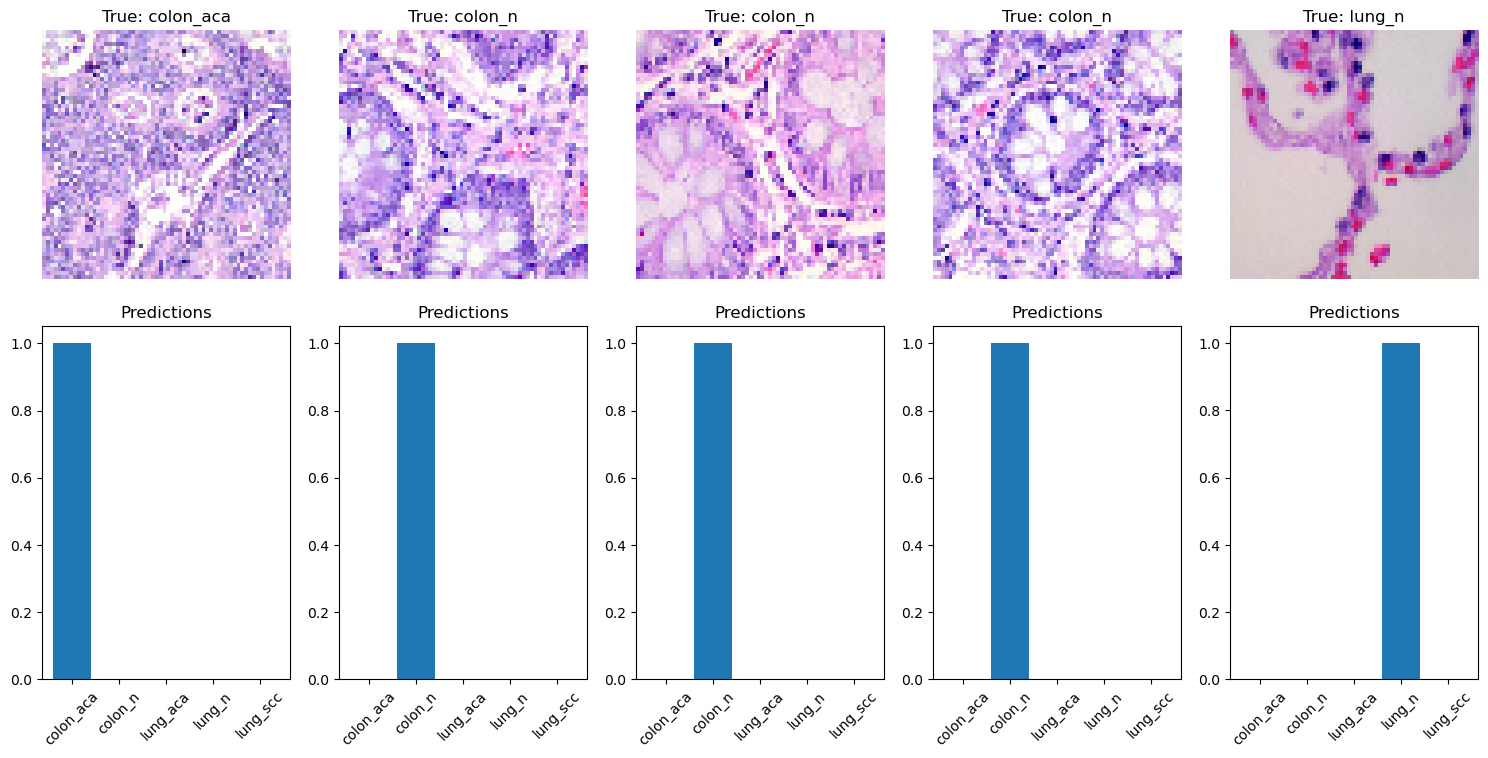

In [ ]:
# Plotting a few sample predictions
def show_sample_predictions(gen, model, num_samples=5):
    classes = list(gen.class_indices.keys())
    
    # Getting a sample batch from the generator
    images, labels = next(gen)

    # Making predictions
    predictions = model.predict(images)

    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {classes[np.argmax(labels[i])]}')
        plt.axis('off')

        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.bar(classes, predictions[i])
        plt.title('Predictions')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Showing sample predictions on the validation set
show_sample_predictions(valid_gen, model)

# Confusion Matrix and Accuracy

In [ ]:
# Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Function to plot a classification report
def plot_classification_report(y_true, y_pred, classes):
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
# Function to plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

8/8 [==============================] - 4s 471ms/step - loss: 0.2349 - accuracy: 0.9480
Test accuracy: 94.80%
8/8 [==============================] - 4s 473ms/step


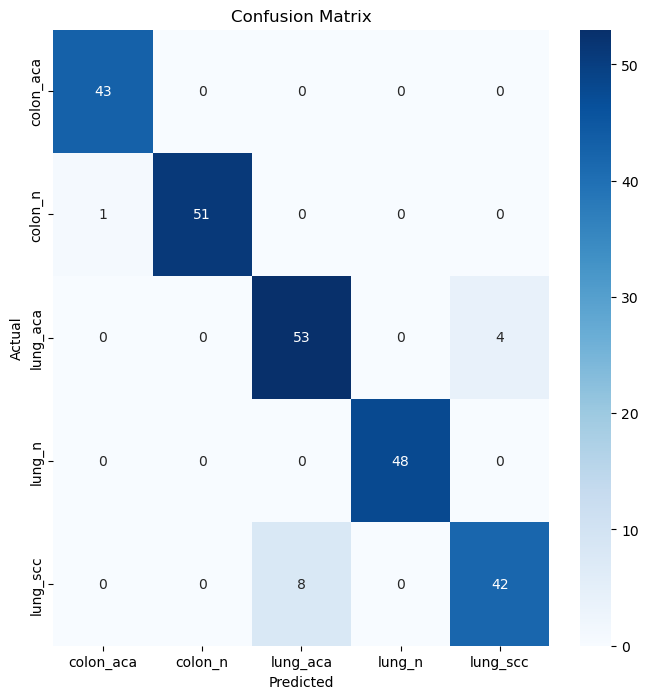

In [ ]:
# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f'Test accuracy: {test_acc * 100:.2f}%')

# Generating predictions on the test set
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = [np.argmax(prob) for prob in y_pred_probs]

# Plotting confusion matrix and classification report
classes = list(test_gen.class_indices.keys())
plot_confusion_matrix(y_true, y_pred, classes)


# Classification Report

In [ ]:
plot_classification_report(y_true, y_pred, classes)

Classification Report:
----------------------
               precision    recall  f1-score   support

   colon_aca       0.98      1.00      0.99        43
     colon_n       1.00      0.98      0.99        52
    lung_aca       0.87      0.93      0.90        57
      lung_n       1.00      1.00      1.00        48
    lung_scc       0.91      0.84      0.87        50

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250

